# Building Psuedosections

In general building a psuedo section plot of resistivity data consists of:
1) Calculating the apparent resistivity.
2) Determining the center of each measurement set.
3) Determing the length of each measurement set.

There are an infinite number of potential configurations of arrays for making measurements, and each has it's own characteristic method of plotting the psuedosections.

For Dipole-Dipole surveys:
    - The horizontal locations are the midpoint of the array
    - The "psuedo-depth" is taken as the number of spacings between ab and mn. i.e.:


In [1]:
import simpeg.electromagnetics.static.resistivity as dc
import simpeg.electromagnetics.static.utils as dc_utils
import numpy as np
import matplotlib.pyplot as plt
import discretize

import pandas as pd

In [2]:
# Electrode array:
# 128 electrodes:
nx = 128
dx = 10 #m
x = np.arange(nx)*dx - 64*dx + dx/2
z = np.zeros_like(x)
elec_locs = np.c_[x, z]

In [3]:
# pole-pole
pole_pole = []
for i in range(128-1):
    start = i+1
    end = min(i+64, 128)
    rxs = dc.receivers.Pole(elec_locs[start:end])
    pole_pole.append(dc.sources.Pole(rxs, elec_locs[i]))

dipole_pole = []
# dipole-pole
for i in range(128 - 2):
    start = i+2
    end = min(i+64, 128)
    rxs = dc.receivers.Pole(elec_locs[start:end])
    
    dipole_pole.append(dc.sources.Dipole(rxs, elec_locs[i], elec_locs[i+1]))


# pole-dipole
pole_dipole = []
for i in range(128 - 2):
    m_start = i+1
    m_end = min(i+64, 128) - 1
    rxs = dc.receivers.Dipole(elec_locs[m_start:m_end], elec_locs[m_start+1:m_end+1])
    pole_dipole.append(dc.sources.Pole(rxs, elec_locs[i]))


dipole_dipole = []
# dipole-dipole
for i in range(128 - 3):
    a = i
    b = i + 1
    m_start = i+2
    m_end = min(i+64, 128) - 1
    rxs = dc.receivers.Dipole(elec_locs[m_start:m_end], elec_locs[m_start+1:m_end+1])
    dipole_dipole.append(dc.sources.Dipole(rxs, elec_locs[i], elec_locs[i+1]))


# wenner-array
wenner = []
for n_spacing in [1, 2, 4, 8, 16, 32]:
    for i in range(0, 128 - 3 * n_spacing):
        a = i
        m = i + n_spacing
        n = i + 2 * n_spacing
        b = i + 3 * n_spacing
        rxs = dc.receivers.Dipole(elec_locs[m], elec_locs[n])
        wenner.append(dc.sources.Dipole(rxs, elec_locs[a], elec_locs[b]))

17126

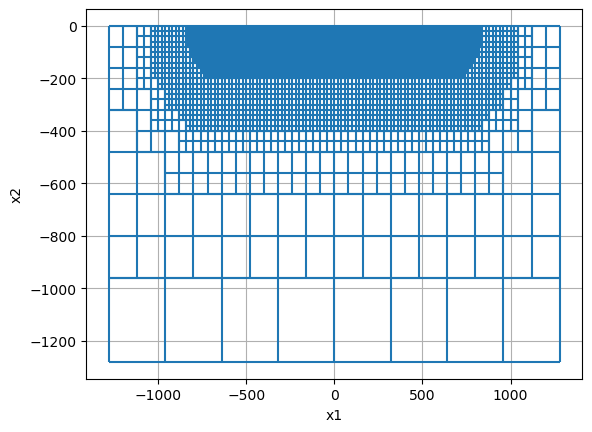

In [5]:
mesh = discretize.TreeMesh([[(2.5, 1024)], [(2.5, 512)]], x0='CN', diagonal_balance=True)
mesh.refine_ball(elec_locs, np.full(elec_locs.shape[0], 50.0), np.full(elec_locs.shape[0], -1), finalize=False)
mesh.refine_ball(elec_locs, np.full(elec_locs.shape[0], 100.0), np.full(elec_locs.shape[0], -2), finalize=False)
mesh.refine_ball(elec_locs, np.full(elec_locs.shape[0], 200.0), np.full(elec_locs.shape[0], -3), finalize=False)
mesh.refine_ball(elec_locs, np.full(elec_locs.shape[0], 400.0), np.full(elec_locs.shape[0], -4), finalize=True)
mesh.plot_grid()
mesh.n_cells

In [129]:
# model = 0.01 * np.ones(mesh.n_cells)
cc = mesh.cell_centers
block_inds = (cc[:, 0] > -50) & (cc[:, 0] < 50) & (cc[:, 1] > -150) & (cc[:, 1] < -50)
model[block_inds] = 1

In [123]:
from matplotlib.colors import LogNorm

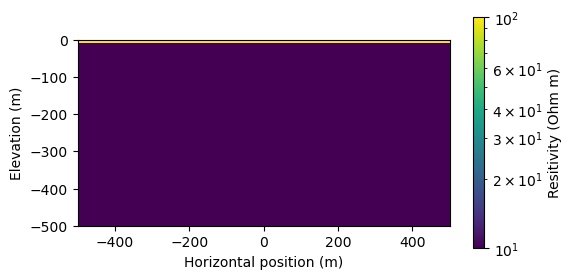

In [124]:
plt.figure(figsize=(6,3))
ax = plt.gca()
im, = mesh.plot_image(1.0/model, ax=ax, pcolor_opts={'norm':LogNorm()})
ax.axis('scaled')
ax.set_xlim([-500, 500])
ax.set_ylim([-500, 0])
ax.set_xlabel('Horizontal position (m)')
ax.set_ylabel('Elevation (m)')

cb = plt.colorbar(im)
cb.set_label('Resitivity (Ohm m)')

In [125]:
s_pp = dc.Survey(pole_pole)
s_dpp = dc.Survey(dipole_pole)
s_pdp = dc.Survey(pole_dipole)
s_dpdp = dc.Survey(dipole_dipole)
s_wen = dc.Survey(wenner)

big_src_list = pole_pole + dipole_pole + pole_dipole + dipole_dipole + wenner

survey = dc.Survey(big_src_list)
breaks = np.cumsum([s_pp.nD, s_dpp.nD, s_pdp.nD, s_dpdp.nD, s_wen.nD])

In [126]:
breaks

array([ 6048, 11969, 17890, 23685, 24264])

In [127]:
sim_pp = dc.Simulation2DNodal(mesh=mesh, survey=survey, miniaturize=True, sigma=model)

In [128]:
dpred = sim_pp.dpred(None)

In [29]:
g = survey.set_geometric_factor().dobs
pa_dpred = dpred / g

v_pp = dpred[:breaks[0]]
v_dpp = dpred[breaks[0]:breaks[1]]
v_pdp = dpred[breaks[1]:breaks[2]]
v_dpdp = dpred[breaks[2]:breaks[3]]
v_wen = dpred[breaks[3]:breaks[4]]

pa_pp = pa_dpred[:breaks[0]]
pa_dpp = pa_dpred[breaks[0]:breaks[1]]
pa_pdp = pa_dpred[breaks[1]:breaks[2]]
pa_dpdp = pa_dpred[breaks[2]:breaks[3]]
pa_wen = pa_dpred[breaks[3]:breaks[4]]

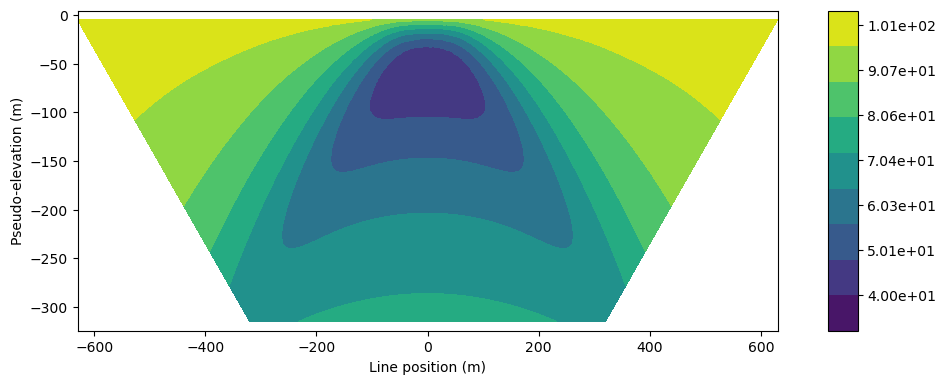

In [33]:
dc_utils.plot_pseudosection(s_pp, pa_pp);

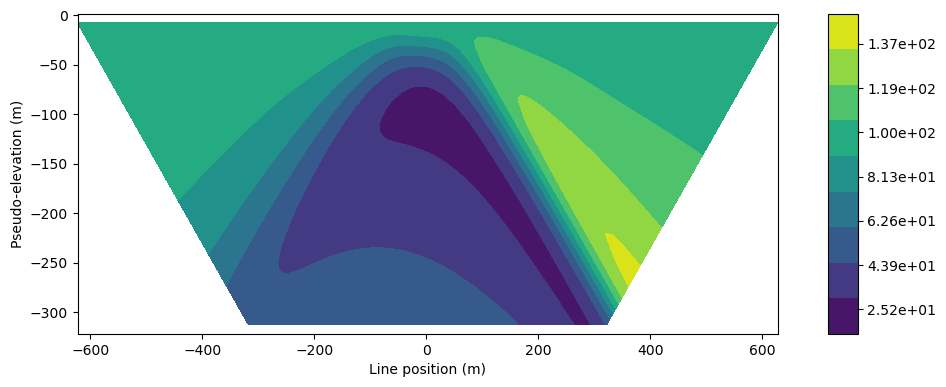

In [34]:
dc_utils.plot_pseudosection(s_dpp, pa_dpp);

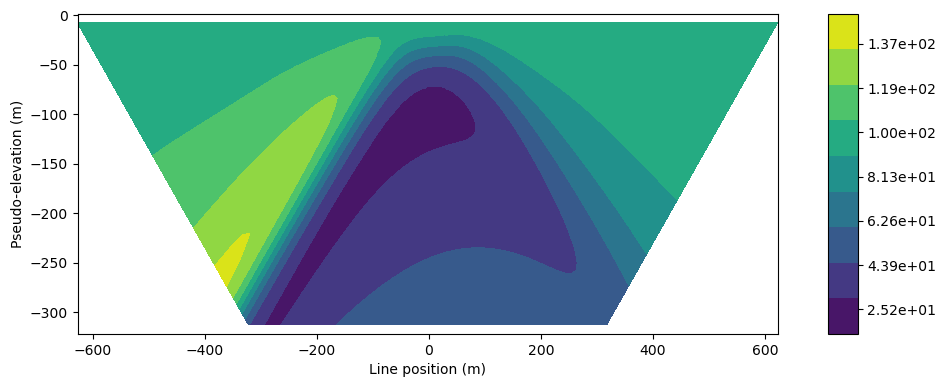

In [35]:
dc_utils.plot_pseudosection(s_pdp, pa_pdp);

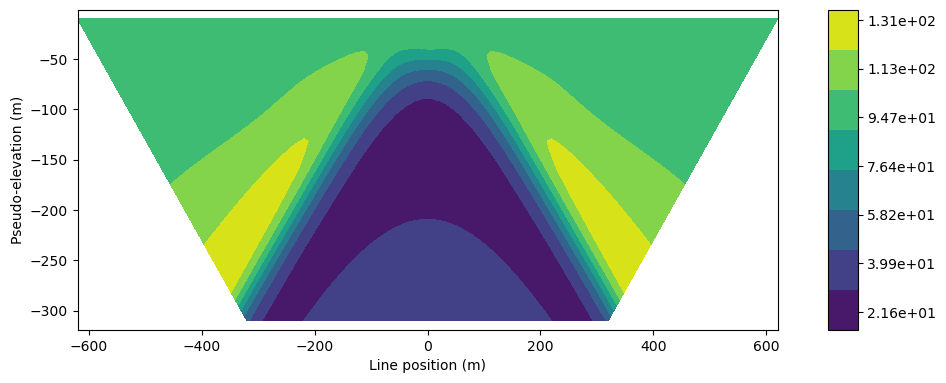

In [36]:
dc_utils.plot_pseudosection(s_dpdp, pa_dpdp);

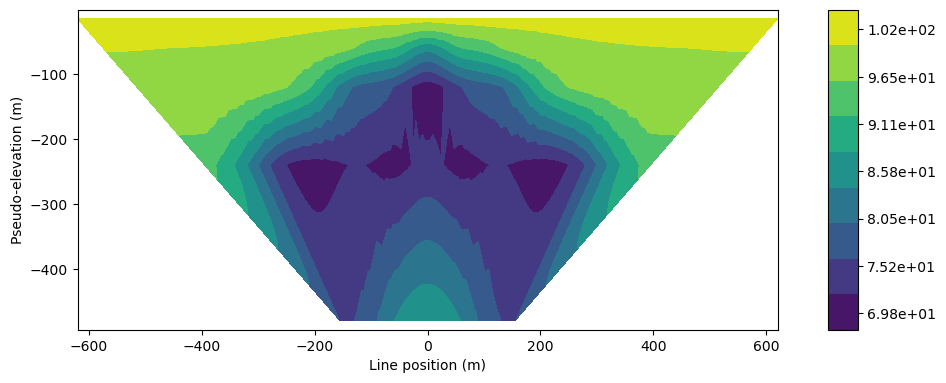

In [32]:
dc_utils.plot_pseudosection(s_wen, pa_wen);

In [82]:
def build_array(survey):
    lines = []
    for src in survey.source_list:
        if isinstance(src, dc.sources.Dipole):
            src_loc = [src.location_a[0], src.location_b[0]]
        else:
            src_loc = [src.location_a[0]]
        for rx in src.receiver_list:
            src_locs = np.repeat(src_loc, rx.nD).reshape(-1, rx.nD).T
            if isinstance(rx, dc.receivers.Dipole):
                rx_locs = np.c_[rx.locations_m[:, 0], rx.locations_n[:, 0]]
            else:
                rx_locs = rx.locations[:, 0][:, None]
            lines.append(np.concatenate([src_locs, rx_locs], axis=1))
    lines = np.concatenate(lines)
    return lines

In [101]:
out_pp = build_array(s_pp)
pp_frame = pd.DataFrame({'A':out_pp[:, 0], 'M':out_pp[:, 1], 'V/I':v_pp})

out_dpp = build_array(s_dpp)
dpp_frame = pd.DataFrame({'A':out_dpp[:, 0], 'B':out_dpp[:, 1], 'M':out_dpp[:, 2], 'V/I':v_dpp})

out_pdp = build_array(s_pdp)
pdp_frame = pd.DataFrame({'A':out_pdp[:, 0], 'M':out_pdp[:, 1], 'N':out_pdp[:, 2], 'V/I':v_pdp})

out_dpdp = build_array(s_dpdp)
dpdp_frame = pd.DataFrame(
    {'A':out_dpdp[:, 0], 'B':out_dpdp[:, 1], 'M':out_dpdp[:, 2], 'N':out_dpdp[:, 3], 'V/I':v_dpdp}
)

out_wen = build_array(s_wen)
wen_frame = pd.DataFrame(
    {'A':out_wen[:, 0], 'B':out_wen[:, 1], 'M':out_wen[:, 2], 'N':out_wen[:, 3], 'V/I':v_wen}
)

In [103]:
pp_frame.to_csv('data/pole_pole.csv')
dpp_frame.to_csv('data/dipole_pole.csv')
pdp_frame.to_csv('data/pole_dipole.csv')
dpdp_frame.to_csv('data/dipole_dipole.csv')
wen_frame.to_csv('data/wenner.csv')